In [1]:
import pandas
import numpy

In [2]:
fsi = pandas.read_csv("data/fragilestatesindex_joined.csv")
psq_tms_clean = pandas.read_csv("data/PSQ_TMS_filtered.csv")
gdp_clean = pandas.read_csv("data/world_bank_gdp/GDP_filtered.csv")
finance_data = pandas.read_csv("data/financial_data.csv")

In [3]:
finance_data_filtered = finance_data[["Country", "WEO Subject Code"] +[str(x) for x in range(2000, 2014)]]
finance_data_filtered.replace("n/a", numpy.nan, inplace=True)
finance_data_filtered = finance_data_filtered[finance_data["WEO Subject Code"] == "NGDPD"]
finance_data_filtered.drop("WEO Subject Code", axis=1, inplace=True)
finance_data_filtered.rename(columns={str(col): "GDP (Billions of USD), " + str(col) for col in range(2000, 2014)}, inplace=True)
finance_data_filtered.rename(columns={"Country": "Country Name"}, inplace=True)

-c:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
joined_data = pandas.merge(psq_tms_clean[["2013", "Country Name"]], fsi, on="Country Name")
joined_data = pandas.merge(joined_data, finance_data_filtered, on="Country Name")
joined_data.rename(columns={"2013" : "Total Refugee Count, 2013"}, inplace=True)
joined_data = joined_data.applymap(lambda x: str(x).replace(",",""))

In [5]:
columns_of_interest = ["Total Refugee Count, 2013"] + ["GDP (Billions of USD), %d" % x for x in range(2000,2014)] + \
                      ["Total %d" % x for x in range(2006,2015)]

In [6]:
joined_data_filtered = joined_data[columns_of_interest]
np_joined = joined_data_filtered.as_matrix().astype("float64")
np_joined = np_joined[~numpy.isnan(np_joined).any(axis=1)]
np_joined[:,0] = np_joined[:,0] / 1000.

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn import covariance

In [8]:
target = np_joined[:,0]
features = np_joined[:,1:]

features_normed = normalize(features, axis=0)

ftrain, ftest, ttrain, ttest = train_test_split(features, target, test_size=0.3, random_state=41234)
ntrain, ntest = train_test_split(features_normed, test_size=0.3, random_state = 41234)
linear_svr = LinearSVR(loss='epsilon_insensitive', epsilon=0, random_state = 12345)

linear_svr.fit(ntrain, ttrain)
preds_normed = linear_svr.predict(ntest)
print numpy.sqrt(metrics.mean_squared_error(ttest, preds_normed))
print metrics.r2_score(ttest, preds_normed)

249.773835775
-0.27197246054


In [9]:
num_models = range(50,300,5)
rmses_ada = []

for n in num_models:
    adaboost = AdaBoostRegressor(n_estimators = n, random_state = 12345)
    adaboost.fit(ntrain, ttrain)
    preds_adaboost = adaboost.predict(ntest)
    rmses_ada.append(numpy.sqrt(metrics.mean_squared_error(ttest, preds_adaboost)))

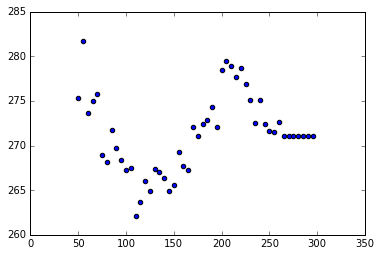

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(num_models, rmses_ada)

In [18]:
adaboost = AdaBoostRegressor(n_estimators = 105, random_state = 12345)

adaboost.fit(ntrain, ttrain)
preds_ada= adaboost.predict(ntest)
print numpy.sqrt(metrics.mean_squared_error(ttest, preds_ada))
print metrics.r2_score(ttest, preds_ada)

267.526479427
-0.459208566552


In [12]:
num_models = range(100,300,5)
rmses_gbt = []

for n in num_models:
    gbt = GradientBoostingRegressor(n_estimators = n, random_state = 12345)
    gbt.fit(ntrain, ttrain)
    preds_gbt = gbt.predict(ntest)
    rmses_gbt.append(numpy.sqrt(metrics.mean_squared_error(ttest, preds_gbt)))

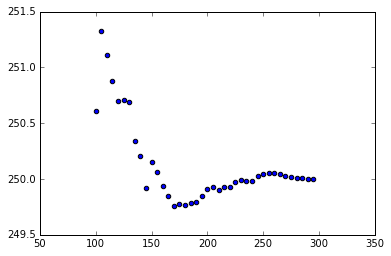

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(num_models, rmses_gbt)

In [17]:
gbt = GradientBoostingRegressor(n_estimators = 160, random_state = 12345)
gbt.fit(ntrain, ttrain)
preds_gbt = gbt.predict(ntest)

print numpy.sqrt(metrics.mean_squared_error(ttest, preds_gbt))
print metrics.r2_score(ttest, preds_gbt)

249.940131816
-0.273666748486
